##### Machine Learning LAB 1: MODEL SELECTION

Course 2025/26: *F. Chiariotti*

The notebook contains a simple learning task over which we will implement **MODEL SELECTION AND VALIDATION**.

Complete all the **required code sections** and **answer all the questions**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## Polynomial Classification on Signal to Noise Ratios

In this notebook we are going to explore the use of polynomial classification with polynomial regression. We are going to use the Numpy **polyfit** function, which performs polynomial regression.

Our use case is a communication problem: we have a set of measurements of the Signal to Noise Ratio (SNR), i.e., the quality of the communication link, in various positions. The SNR depends on two components: firstly, the noise level (which is a random variable that does not depend on position) and the signal attenuation (usually modeled as a polynomial function of the distance).

Our transmitter is in (0,0), and coordinates are in meters. In urban scenarios, the attenuation usually follows a third-degree polynomial, but it might be a fourth- or fifth-degree polynomial in more complex cases. How do we choose between different degrees? We will try with a maximum of **6**

---

## Import all the necessary Python libraries

In [181]:
import numpy as np
import scipy as sp
import pandas as pd
import itertools
import random
from matplotlib import pyplot as plt

---

## Load the data

In this case, x and y are the two coordinates, and the SNR is the thing we are trying to predict

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [182]:
df = pd.read_csv('data/snr_measurements.csv',sep=';')
x = df['x'].to_numpy()
y = df['y'].to_numpy()
SNR = df['SNR'].to_numpy()

## Helper functions

These functions will help us evaluate the results

In [183]:
def compute_distance(x, y):
    # Compute the Euclidean distance from the origin
    distance = np.sqrt(x**2 + y**2)
    return distance

def fit(distance, SNR, degree):
    return np.polyfit(distance, SNR, deg=degree)

def predict(distance, poly_coeffs):
    # Predict the SNR from a given model
    SNR = 0
    deg = len(poly_coeffs)
    for i,c in enumerate(poly_coeffs):
        SNR += c * distance**(deg - i - 1)
    return SNR

def evaluate(distance, SNR, poly_coeffs):
    # Compute the error of the polynomial fit on the chosen data
    mse = 0
    for d,s in zip(distance, SNR):
        mse += (predict(d, poly_coeffs) - s)**2
    mse /= len(distance)
    return mse

def separate_test(distance, SNR, test_points):
    # Return a training set and a test set (the test_points parameter controls the number of test points).
    # The points should be selected randomly
    test_index = random.sample(range(len(distance)), test_points)
    train_index = [i for i in range(len(distance)) if i not in test_index]
    x_test = distance[test_index]
    y_test = SNR[test_index]
    x_train = distance[train_index]
    y_train = SNR[train_index]

    return x_train, y_train, x_test, y_test

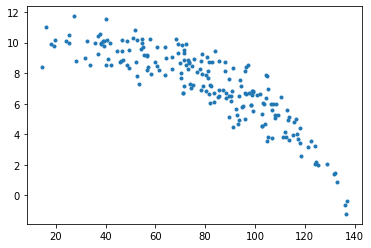

In [184]:
# Separate the training and test sets and create a scatter plot of the SNR as a function of the distance
distance = compute_distance(x, y)
plt.scatter(distance, SNR, marker='.')

## A. K-fold cross-validation

In this case, x and y are the two coordinates, and the SNR is the thing we are trying to predict

In [185]:
# Function to perform the K-fold cross validation
def k_fold_cross_validation(x_train: np.ndarray, y_train: np.ndarray, k: int, max_degree: int) -> tuple[tuple, tuple]:
    # Perform K-fold cross-validation on the training set.
    # The two returned values are the best model and the list of results for all degrees up to max_degree.
    # The points should be selected randomly.
    # The inputs and labels are already in terms of distance and SNR

    # Dividing training set into folds
    x_folds = []
    y_folds = []
    index = range(len(x_train))
    fold_points = int(len(index) / k)
    for f in range(k):
        fold_index = random.sample(index, fold_points)
        index = [i for i in index if i not in fold_index]
        x_folds.append(x_train[fold_index])
        y_folds.append(y_train[fold_index])
    
    # Training
    best = -1
    error_best = 1e10
    results = []
    for d in range(max_degree + 1):
        loss_d = 0.0
        for f in range(k):
            x_train_f = [x for i,x in enumerate(x_folds[f]) if i != f]
            y_train_f = [y for i,y in enumerate(y_folds[f]) if i != f]
            par_f = fit(x_train_f, y_train_f, d)
            loss_d += evaluate(x_folds[f], y_folds[f], par_f)
        loss_d /= k
        results.append(loss_d)
        if loss_d < error_best:
            best = fit(x_train, y_train, d)
            error_best = loss_d
        
    return best, results

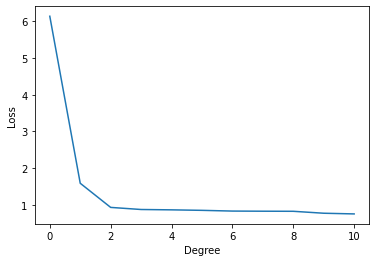

In [186]:
# Run the training with K-fold cross-validation with 40 test points and 4 folds. Plot the validation score as a function of the degree
test_points = 40
folds = 4
max_degree = 10

distance = compute_distance(x, y)
x_train, y_train, x_test, y_test = separate_test(distance, SNR, test_points)
best, results = k_fold_cross_validation(x_train, y_train, folds, max_degree)

plt.plot(range(max_degree + 1), results)
plt.xlabel('Degree')
plt.ylabel('Loss')
plt.show()

Loss of the test set:  0.9429703055641875
[-1.47140370e-16  1.10715107e-13 -3.62958222e-11  6.80668395e-09
 -8.05955539e-07  6.27202286e-05 -3.23440003e-03  1.08557961e-01
 -2.25534142e+00  2.59867996e+01 -1.15126170e+02]


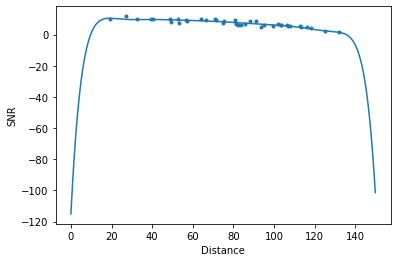

In [187]:
# Get the test performance of the best model and plot the model output and test points. 
# Try running the program multiple times, changing the values of K and the number of test points: is the output always the same?
print("Loss of the test set: ", evaluate(x_test, y_test, best))
print(best)
plt.scatter(x_test, y_test, marker='.')

dist_value = np.arange(0,150,0.1)
SNR_value = predict(dist_value, best)
plt.plot(dist_value, SNR_value)
plt.xlabel('Distance')
plt.ylabel('SNR')
plt.show()


---

## B. Tikhonov regularization

Change the loss function to include a Tikhonov regularization term, as an alternative to cross-validation (try $\lambda=0.01$)

In [188]:
def evaluate_tikhonov(x_train: np.ndarray, y_train: np.ndarray, lambda_par: float, max_degree: int) -> tuple[tuple, tuple]:
    # Apply Tikhonov regularization AFTER the fitting process
    best = -1
    error_best = 1e10
    results = []
    for d in range(max_degree + 1):
        par = fit(x_train, y_train, d)
        loss = evaluate(x_train, y_train, par) + lambda_par * np.sum(par ** 2)
        results.append(loss)
        if loss < error_best:
            best = par
            error_best = loss
    return best, results

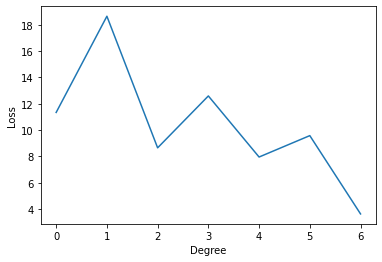

In [189]:
# Run the training with Tikhonov regularization and plot the loss as a function of the degree
lambda_par = 0.1
max_degree = 6

distance = compute_distance(x, y)
x_train, y_train, x_test, y_test = separate_test(distance, SNR, test_points)
best_t, results_t = evaluate_tikhonov(x_train, y_train, lambda_par, max_degree)

plt.plot(range(max_degree + 1), results_t)
plt.xlabel('Degree')
plt.ylabel('Loss')
plt.show()


## C. Minimum description length regularization

Change the loss function to include a representation length regularization term, as an alternative to cross-validation. The minimum description length of a polynomial of degree N is O(2^N) - try $\lambda=0.02$

In [190]:
def evaluate_representation(x_train: np.ndarray, y_train: np.ndarray, lambda_par: float, max_degree: int) -> tuple[tuple, tuple]:
    # Apply minimum description length regularization AFTER the fitting process
    best = -1
    error_best = 1e10
    results = []
    for d in range(max_degree + 1):
        par = fit(x_train, y_train, d)
        loss = evaluate(x_train, y_train, par) + lambda_par * 2**d
        results.append(loss)
        if loss < error_best:
            best = par
            error_best = loss
    return best, results

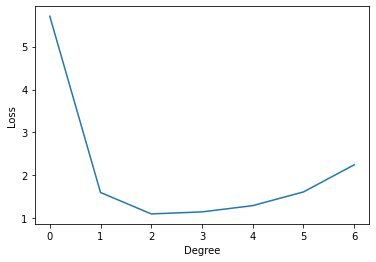

In [191]:
# Run the training with MDL regularization and plot the loss as a function of the degree
lambda_par = 0.02
max_degree = 6

distance = compute_distance(x, y)
x_train, y_train, x_test, y_test = separate_test(distance, SNR, test_points)
best_m, results_m = evaluate_representation(x_train, y_train, lambda_par, max_degree)

plt.plot(range(max_degree + 1), results_m)
plt.xlabel('Degree')
plt.ylabel('Loss')
plt.show()

### TEST

Check the performance of the three solutions on the test set: which one does best?


K-fold: 
 [-1.47140370e-16  1.10715107e-13 -3.62958222e-11  6.80668395e-09
 -8.05955539e-07  6.27202286e-05 -3.23440003e-03  1.08557961e-01
 -2.25534142e+00  2.59867996e+01 -1.15126170e+02] 
Loss:  0.6111224172484575 

Tikhonov: 
 [-7.20921478e-11  3.18072511e-08 -5.62298979e-06  5.02875571e-04
 -2.41797719e-02  5.62752314e-01  5.17317319e+00] 
Loss:  0.6896099912965982 

MDL: 
 [-8.02639425e-04  4.96693148e-02  9.02684244e+00] 
Loss:  0.72799914055544 



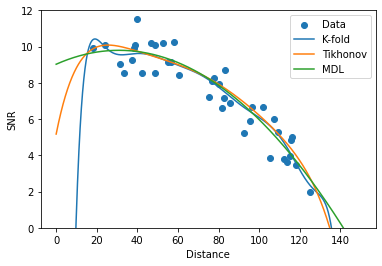

In [192]:
# TODO: plot the results
print("K-fold: \n", best, "\nLoss: ", evaluate(x_test, y_test, best), "\n")
print("Tikhonov: \n", best_t, "\nLoss: ", evaluate(x_test, y_test, best_t), "\n")
print("MDL: \n", best_m, "\nLoss: ", evaluate(x_test, y_test, best_m), "\n")


plt.scatter(x_test, y_test, label='Data')
dist_value = np.arange(0,150,0.1)
SNR_value = np.zeros(1500)
SNR_value_t = np.zeros(1500)
SNR_value_m = np.zeros(1500)
SNR_value = predict(dist_value, best)
SNR_value_t = predict(dist_value, best_t)
SNR_value_m = predict(dist_value, best_m)
plt.plot(dist_value, SNR_value, label='K-fold')
plt.plot(dist_value, SNR_value_t, label='Tikhonov')
plt.plot(dist_value, SNR_value_m, label='MDL')
plt.xlabel('Distance')
plt.ylabel('SNR')
plt.ylim(0, 12)
plt.legend()
plt.show()
